In [1]:
MODELO = "InceptionV3-FineTune"

In [2]:
import os
import keras
keras.__version__
import numpy as np
import pandas as pd
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


### Multi - GPU

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [4]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [5]:
keras.backend.tensorflow_backend.set_session(get_session())

# Directorios

In [6]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


# Modelo InceptionV3

In [8]:
from keras.applications import InceptionV3

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(299, 299, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

# Trainable Layers

In [10]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'mixed9':
        set_trainable = True
    layer.trainable = set_trainable

In [11]:
# Después de modificar el atributo trainable
for layer in conv_base.layers:
  print(layer.name, layer.trainable)

input_1 False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
conv2d_3 False
batch_normalization_3 False
activation_3 False
max_pooling2d_1 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
conv2d_5 False
batch_normalization_5 False
activation_5 False
max_pooling2d_2 False
conv2d_9 False
batch_normalization_9 False
activation_9 False
conv2d_7 False
conv2d_10 False
batch_normalization_7 False
batch_normalization_10 False
activation_7 False
activation_10 False
average_pooling2d_1 False
conv2d_6 False
conv2d_8 False
conv2d_11 False
conv2d_12 False
batch_normalization_6 False
batch_normalization_8 False
batch_normalization_11 False
batch_normalization_12 False
activation_6 False
activation_8 False
activation_11 False
activation_12 False
mixed0 False
conv2d_16 False
batch_normalization_16 False
activation_16 False
conv2d_14 False
conv2d_17 False
batch_normalization_14 False
batch_normalization_17 F

# Model

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 55,388,312
Trainable params: 39,659,064
Non-trainable params: 15,729,248
_________________________________________________________________


# Optimizador

In [13]:
from keras_radam import RAdam

model.compile(loss='categorical_crossentropy',
                       optimizer=RAdam(total_steps=5000, warmup_proportion=0.1, min_lr=1e-7),
                       metrics=['categorical_accuracy'])

# Callbacks

In [14]:
from keras import callbacks

callbacks = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', min_delta=0.001, patience=20, restore_best_weights=True, mode='max')]

# Entrenamiento

In [15]:
history = model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=2000,
                                       validation_data=valid_generator,
                                       validation_steps=50,
                                       callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
100/100 [==============================] - 118s 1s/step - loss: 4.6588 - categorical_accuracy: 0.0616 - val_loss: 2.8459 - val_categorical_accuracy: 0.4156
Epoch 2/2000
100/100 [==============================] - 89s 893ms/step - loss: 2.7401 - categorical_accuracy: 0.3787 - val_loss: 0.9966 - val_categorical_accuracy: 0.7256
Epoch 3/2000
100/100 [==============================] - 83s 829ms/step - loss: 2.1745 - categorical_accuracy: 0.4844 - val_loss: 1.1615 - val_categorical_accuracy: 0.7025
Epoch 4/2000
100/100 [==============================] - 86s 856ms/step - loss: 2.2672 - categorical_accuracy: 0.4691 - val_loss: 1.3696 - val_categorical_accuracy: 0.6795
Epoch 5/2000
100/100 [==============================] - 77s 773ms/step - loss: 2.4586 - categorical_accuracy: 0.4416 - val_loss: 1.2969 - val_categorical_accuracy: 0.7044
Epoch 6/2000
100/100 [==============================] - 69s 689ms/step - loss: 2.2090 - categorical

100/100 [==============================] - 69s 689ms/step - loss: 0.4215 - categorical_accuracy: 0.8681 - val_loss: 0.6056 - val_categorical_accuracy: 0.8300
Epoch 48/2000
100/100 [==============================] - 69s 692ms/step - loss: 0.3814 - categorical_accuracy: 0.8744 - val_loss: 0.6536 - val_categorical_accuracy: 0.8303
Epoch 49/2000
100/100 [==============================] - 69s 687ms/step - loss: 0.4212 - categorical_accuracy: 0.8719 - val_loss: 0.6644 - val_categorical_accuracy: 0.8194
Epoch 50/2000
100/100 [==============================] - 69s 691ms/step - loss: 0.4123 - categorical_accuracy: 0.8709 - val_loss: 0.5404 - val_categorical_accuracy: 0.8429
Epoch 51/2000
100/100 [==============================] - 70s 701ms/step - loss: 0.3687 - categorical_accuracy: 0.8925 - val_loss: 0.6726 - val_categorical_accuracy: 0.8313
Epoch 52/2000
100/100 [==============================] - 69s 695ms/step - loss: 0.4063 - categorical_accuracy: 0.8738 - val_loss: 0.5867 - val_categorical

In [16]:
import pickle

# open a file, where you ant to store the data
file = open('./models/history_{}.pkl'.format(MODELO), 'wb')

# dump information to that file
pickle.dump(history.history, file)

# close the file
file.close()

# Graficos

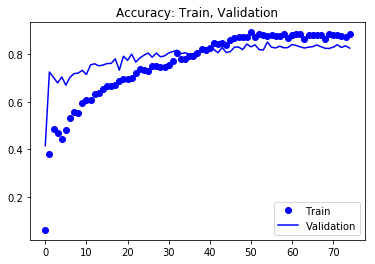

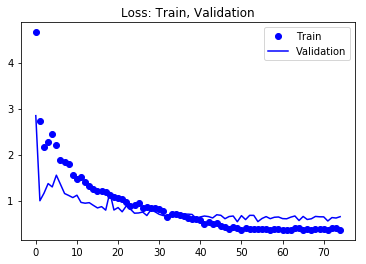

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [22]:
model.save('./models/model_{}_RAdam.h5'.format(MODELO))

# Predict

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=32,
        class_mode=None,
        shuffle=False)

Found 3025 images belonging to 120 classes.


In [26]:
probabilities = model.predict_generator(test_generator)

In [27]:
# Get Max Index
predicted_class_index=np.argmax(probabilities,axis=1)

# Dictionary: Index to Class
class_labels = list(test_generator.class_indices.keys())
index_to_labels = dict((v,k) for k,v in test_generator.class_indices.items())

# Get List of Predictions
predictions = [index_to_labels[ix] for ix in predicted_class_index]

# Get Dictionary of Predictions
results=pd.DataFrame({"Filename":test_generator.filenames,
                      "Predictions":predictions})

In [28]:
results.head()

,Filename,Predictions
0,n02085620-Chihuahua\n02085620_10074.jpg,n02085620-Chihuahua
1,n02085620-Chihuahua\n02085620_10131.jpg,n02085620-Chihuahua
2,n02085620-Chihuahua\n02085620_10621.jpg,n02085620-Chihuahua
3,n02085620-Chihuahua\n02085620_1073.jpg,n02085620-Chihuahua
4,n02085620-Chihuahua\n02085620_10976.jpg,n02085620-Chihuahua


In [29]:
results.to_csv("./models/results_details_{}.csv".format(MODELO), sep="|", index=False)

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_generator.labels, predicted_class_index)

In [31]:
results_dict = {}
tp_sum, fp_sum = 0, 0

for ix, row in enumerate(cm):
    
    tp = row[ix]
    fp = np.sum(row) - tp   
    results_dict[ix] = [class_labels[ix],tp,fp,(tp/(tp+fp)*100)]

    tp_sum += tp
    fp_sum += fp
    
df_res = pd.DataFrame.from_dict(results_dict, orient="index", columns=["Class","True Positive","False Positive","Accuracy"])

print("General Accuracy:{:0.2f}".format(tp_sum/(tp_sum+fp_sum)))

General Accuracy:0.83


In [32]:
df_res.head()

,Class,True Positive,False Positive,Accuracy
0,n02085620-Chihuahua,21,1,95.454545
1,n02085782-Japanese_spaniel,25,2,92.592593
2,n02085936-Maltese_dog,32,5,86.486486
3,n02086079-Pekinese,19,3,86.363636
4,n02086240-Shih-Tzu,27,5,84.375000


In [33]:
df_res.to_csv("./models/results_{}.csv".format(MODELO), sep="|", index=False)